**Testing the Final Model**

The purpose of this notebook is to evaluate the performance of our selected model on the test data we set aside at the beginning of this process.

In [6]:
# Import everything we need
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from imblearn.over_sampling import SMOTE
from sklearn.metrics import cohen_kappa_score
from CustomImputers import *

**Loading the Data and Creating Lists**

In this section, we'll load the data (cleaned, with unnecessary features already removed) and create lists of predictors based on previous exploration

For the purpose of developing our model(s), we'll work with data that include the imputed outcome (PCIAT_Total and/or sii) scores AND have cleaned predictors.

In the final version of our code (which we'll submit to Kaggle), we'll work with data with cleaned predictors but won't have any access to the outcome scores.

In [2]:
#Load the cleaned & outcome-imputed data
train_cleaned=pd.read_csv('train_cleaned_outcome_imputed_feature_selected.csv')

In [3]:
#Create an initial list of predictor columns

predictors = train_cleaned.columns.tolist()
if 'id' in predictors:
    predictors.remove('id')
if 'sii' in predictors:
    predictors.remove('sii')
predictors = [x for x in predictors if 'PCIAT' not in x]
predictors = [x for x in predictors if 'Season' not in x]

# Create an augmented list that will be used for 
predictors_plus = predictors + ['PCIAT-PCIAT_Total']

# The Fitness_Endurance predictor was creating havoc with the MLR models, so we'll omit it from the predictor list for those models
predictors_less = [x for x in predictors if 'Fitness_Endurance_Total_Time_Sec' not in x]

In [4]:
#Import the full test set (from our original train-test split.)
test=pd.read_csv('test_cleaned_feature_selected.csv')

#Drop the rows that have no sii value reported.
test= test.dropna(subset=['sii'])

In [ ]:
# Set up SMOTE to create 128 (rather than 32) instances of sii=3
siiratios = {0: 1228, 1: 619, 2:315, 3:128}
oversample = SMOTE(sampling_strategy=siiratios)

#We now generate a model using the full train set (from our original train-test split.)

# Impute missing values
mice = Custom_MICE_Imputer()
train = mice.fit_transform(train_cleaned)
train = zone_encoder(train)
test = mice.fit_transform(test)
test = zone_encoder(test)

# Oversample with SMOTE
X, y = oversample.fit_resample(train[predictors_plus], train['sii'])

# Create the gradient boost model suggested by the tuning
grad_pciat=GradientBoostingRegressor(learning_rate=0.1, max_depth= 3, max_features= 10, min_samples_leaf= 8, min_samples_split= 3, n_estimators= 50)

# Fit and make predictions
grad_pciat.fit(X[predictors_less], X['PCIAT-PCIAT_Total'])
pred = grad_pciat.predict(test[predictors_less])

# "Tuned" bins.
bins_mod = [0, 27, 39, 79, 100]
pred_bin_mod = np.digitize(pred, bins_mod)-1

final_kappa = cohen_kappa_score(test['sii'], pred_bin_mod, weights='quadratic')

print('Cohens Kappa Score:', final_kappa)

Cohens Kappa Score 0.4461275400539233


**Interpretation**

The kappa score varies a bit from run to run, but is consistently above 0.44, sometimes above 0.46. This is usually interpreted as "moderate" agreement between the predicted and actual scores.

We can examine a confusion matrix to better understand how our predictions are falling short

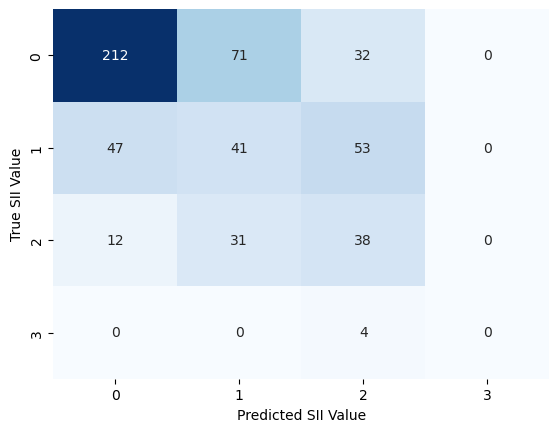

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cf_matrix = confusion_matrix(test['sii'], pred_bin_mod)

#group_counts = ["{0:0.0f}\n".format(value) for value in cf_matrix.flatten()]
#group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
#box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_counts,group_percentages)]
#box_labels = np.asarray(box_labels).reshape(cf_matrix.shape[0],cf_matrix.shape[1])
figsize = plt.rcParams.get('figure.figsize')
plt.figure(figsize=figsize)
#sns.heatmap(cf_matrix,annot=box_labels,fmt="",cmap='Blues',cbar=False,xticklabels=True,yticklabels=True)
sns.heatmap(cf_matrix,annot=True,fmt="",cmap='Blues',cbar=False,xticklabels=True,yticklabels=True)
plt.ylabel('True SII Value')
plt.xlabel('Predicted SII Value')
#plt.title(title)
plt.show()


**Discussion**

There were only 4 instances of an sii value of 3, and we didn't correctly predict any of these - despite our use of SMOTE to help our model do just this.

Our predictions didn't fare particularly well for any of the true SII values: 
* For sii=2, although 2 was the plurality prediction, we were more likely to predict a 0 or 1 than a 2.
* For sii=1, we were roughly equally likely to predict a 0, 1, or 2
* For sii=0, we were most likely to predict a 0.